### Import Modules

In [1]:
import numpy as np
import torch
import torch.nn as nn

In [2]:
from models.custom_resnet import CustomResnet
from utils.data import train_dataset, test_dataset
from utils.training import train, test

from utils.common import (
    find_lr,
    one_cycle_lr,
    show_model_summary,
    show_img_grid,
    show_random_images,
    show_random_images_for_each_class,
)

Files already downloaded and verified
Files already downloaded and verified


/home/ravi.naik/miniconda3/envs/torchenv/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Create Dataloaders

In [3]:
batch_size = 512
shuffle = True
num_workers = 4

In [4]:
trainloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,
)

testloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,
)

### Check Sample Images

In [5]:
images, labels = next(iter(trainloader))

In [6]:
images[0].shape, labels[0]

(torch.Size([3, 32, 32]), tensor(9))

In [7]:
print(train_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


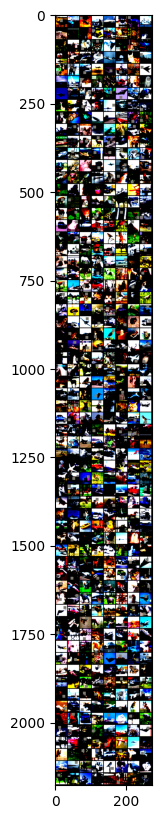

In [8]:
show_random_images(data_loader=trainloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


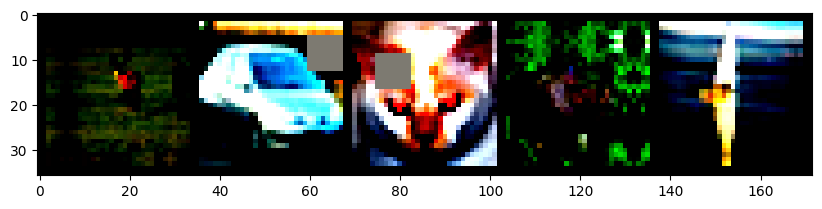

In [9]:
show_img_grid(images[25:30])

### Set Device

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
device

'cuda'

### Generate Model Summary

In [12]:
model = CustomResnet().to(device)

In [13]:
show_model_summary(model, batch_size)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
CustomResnet                             [512, 3, 32, 32]          [512, 10]                 --                        --
├─Sequential: 1-1                        [512, 3, 32, 32]          [512, 64, 32, 32]         --                        --
│    └─Conv2d: 2-1                       [512, 3, 32, 32]          [512, 64, 32, 32]         1,728                     [3, 3]
│    └─BatchNorm2d: 2-2                  [512, 64, 32, 32]         [512, 64, 32, 32]         128                       --
│    └─ReLU: 2-3                         [512, 64, 32, 32]         [512, 64, 32, 32]         --                        --
├─Sequential: 1-2                        [512, 64, 32, 32]         [512, 128, 16, 16]        --                        --
│    └─Conv2d: 2-4                       [512, 64, 32, 32]         [512, 128, 32, 32]        73,728                    [3, 3]
│    └

### Declare Optimizer & Criterion

In [14]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.003, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

### Find LR

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.53E-03


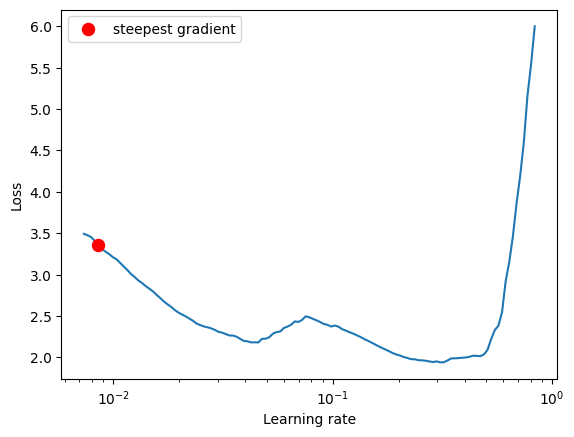

In [15]:
find_lr(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    trainloader=trainloader,
    numiter=200,
    endlr=10,
    startlr=5e-3,
)

### Create the Scheduler - One Cycle Policy

In [16]:
epochs = 24
maxlr = 8.53e-03
scheduler = one_cycle_lr(
    optimizer=optimizer, maxlr=maxlr, steps=len(trainloader), epochs=epochs
)

### Model Training & Evaluation

In [17]:
results = dict(trainloss=[], trainacc=[], testloss=[], testacc=[], epoch=[])

for epoch in range(1, epochs + 1):
    print(f"Epoch: {epoch}")

    batch_trainloss, batch_trainacc = train(
        model=model,
        device=device,
        optimizer=optimizer,
        criterion=criterion,
        train_loader=trainloader,
    )

    results["trainloss"].append(np.mean(batch_trainloss))
    results["trainacc"].append(np.mean(batch_trainacc))

    testloss, testacc = test(
        model=model, device=device, criterion=criterion, test_loader=testloader
    )
    results["testloss"].append(testloss)
    results["testacc"].append(testacc)

    scheduler.step()

Epoch: 1


Loss=1.1312211751937866 Batch_id=97 Accuracy=46.03: 100%|██████████| 98/98 [00:06<00:00, 15.79it/s]



Test set: Average loss: 1.1598, Accuracy: 5849/10000 (58.49%)

Epoch: 2


Loss=1.004176139831543 Batch_id=97 Accuracy=61.26: 100%|██████████| 98/98 [00:06<00:00, 15.96it/s] 



Test set: Average loss: 0.9541, Accuracy: 6633/10000 (66.33%)

Epoch: 3


Loss=0.7684246301651001 Batch_id=97 Accuracy=67.84: 100%|██████████| 98/98 [00:06<00:00, 15.64it/s]



Test set: Average loss: 0.8314, Accuracy: 7102/10000 (71.02%)

Epoch: 4


Loss=0.8225710988044739 Batch_id=97 Accuracy=72.11: 100%|██████████| 98/98 [00:06<00:00, 15.89it/s]



Test set: Average loss: 0.7321, Accuracy: 7438/10000 (74.38%)

Epoch: 5


Loss=0.6766724586486816 Batch_id=97 Accuracy=75.50: 100%|██████████| 98/98 [00:05<00:00, 16.42it/s]



Test set: Average loss: 0.6890, Accuracy: 7582/10000 (75.82%)

Epoch: 6


Loss=0.5597816705703735 Batch_id=97 Accuracy=78.16: 100%|██████████| 98/98 [00:06<00:00, 15.83it/s]



Test set: Average loss: 0.6655, Accuracy: 7742/10000 (77.42%)

Epoch: 7


Loss=0.6315930485725403 Batch_id=97 Accuracy=80.47: 100%|██████████| 98/98 [00:06<00:00, 15.58it/s] 



Test set: Average loss: 0.5701, Accuracy: 7992/10000 (79.92%)

Epoch: 8


Loss=0.46268531680107117 Batch_id=97 Accuracy=82.22: 100%|██████████| 98/98 [00:06<00:00, 15.91it/s]



Test set: Average loss: 0.5530, Accuracy: 8056/10000 (80.56%)

Epoch: 9


Loss=0.44186273217201233 Batch_id=97 Accuracy=83.70: 100%|██████████| 98/98 [00:06<00:00, 15.88it/s]



Test set: Average loss: 0.5206, Accuracy: 8182/10000 (81.82%)

Epoch: 10


Loss=0.3845616281032562 Batch_id=97 Accuracy=84.92: 100%|██████████| 98/98 [00:06<00:00, 15.73it/s] 



Test set: Average loss: 0.5482, Accuracy: 8162/10000 (81.62%)

Epoch: 11


Loss=0.3804352283477783 Batch_id=97 Accuracy=85.79: 100%|██████████| 98/98 [00:06<00:00, 15.55it/s] 



Test set: Average loss: 0.5432, Accuracy: 8208/10000 (82.08%)

Epoch: 12


Loss=0.3882497549057007 Batch_id=97 Accuracy=87.04: 100%|██████████| 98/98 [00:06<00:00, 15.48it/s] 



Test set: Average loss: 0.4929, Accuracy: 8343/10000 (83.43%)

Epoch: 13


Loss=0.3549358546733856 Batch_id=97 Accuracy=87.77: 100%|██████████| 98/98 [00:06<00:00, 16.06it/s] 



Test set: Average loss: 0.4423, Accuracy: 8508/10000 (85.08%)

Epoch: 14


Loss=0.30777105689048767 Batch_id=97 Accuracy=88.55: 100%|██████████| 98/98 [00:06<00:00, 15.90it/s]



Test set: Average loss: 0.4496, Accuracy: 8437/10000 (84.37%)

Epoch: 15


Loss=0.2841372489929199 Batch_id=97 Accuracy=89.25: 100%|██████████| 98/98 [00:06<00:00, 15.96it/s] 



Test set: Average loss: 0.4715, Accuracy: 8408/10000 (84.08%)

Epoch: 16


Loss=0.32427167892456055 Batch_id=97 Accuracy=89.91: 100%|██████████| 98/98 [00:06<00:00, 15.71it/s]



Test set: Average loss: 0.4142, Accuracy: 8604/10000 (86.04%)

Epoch: 17


Loss=0.22306805849075317 Batch_id=97 Accuracy=90.34: 100%|██████████| 98/98 [00:06<00:00, 15.59it/s]



Test set: Average loss: 0.4120, Accuracy: 8661/10000 (86.61%)

Epoch: 18


Loss=0.2989561855792999 Batch_id=97 Accuracy=91.02: 100%|██████████| 98/98 [00:06<00:00, 15.76it/s] 



Test set: Average loss: 0.4102, Accuracy: 8652/10000 (86.52%)

Epoch: 19


Loss=0.25593677163124084 Batch_id=97 Accuracy=91.52: 100%|██████████| 98/98 [00:06<00:00, 15.45it/s]



Test set: Average loss: 0.4391, Accuracy: 8611/10000 (86.11%)

Epoch: 20


Loss=0.22611556947231293 Batch_id=97 Accuracy=91.85: 100%|██████████| 98/98 [00:06<00:00, 15.54it/s]



Test set: Average loss: 0.3677, Accuracy: 8732/10000 (87.32%)

Epoch: 21


Loss=0.23785807192325592 Batch_id=97 Accuracy=92.11: 100%|██████████| 98/98 [00:06<00:00, 15.64it/s]



Test set: Average loss: 0.3853, Accuracy: 8739/10000 (87.39%)

Epoch: 22


Loss=0.2168503999710083 Batch_id=97 Accuracy=92.52: 100%|██████████| 98/98 [00:06<00:00, 15.85it/s] 



Test set: Average loss: 0.4365, Accuracy: 8575/10000 (85.75%)

Epoch: 23


Loss=0.2249038815498352 Batch_id=97 Accuracy=93.02: 100%|██████████| 98/98 [00:06<00:00, 15.41it/s] 



Test set: Average loss: 0.5034, Accuracy: 8501/10000 (85.01%)

Epoch: 24


Loss=0.173559308052063 Batch_id=97 Accuracy=93.37: 100%|██████████| 98/98 [00:06<00:00, 15.62it/s]  



Test set: Average loss: 0.3906, Accuracy: 8744/10000 (87.44%)



In [18]:
import matplotlib.pyplot as plt

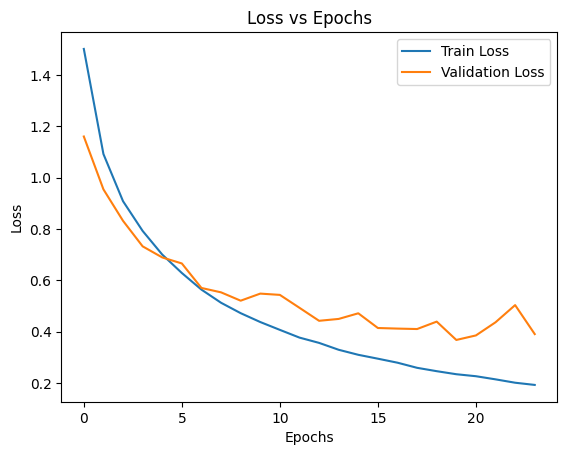

In [19]:
plt.plot(range(epochs), results["trainloss"])
plt.plot(range(epochs), results["testloss"])
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

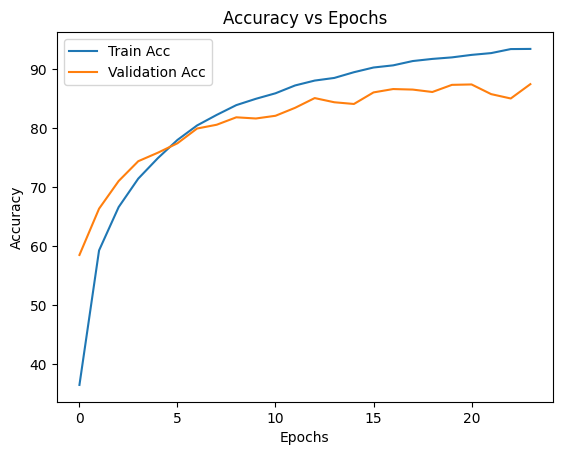

In [20]:
plt.plot(range(epochs), results["trainacc"])
plt.plot(range(epochs), results["testacc"])
plt.legend(["Train Acc", "Validation Acc"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.show()